In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [3]:
df_2017 = pd.read_csv('/Users/rakesh/Documents/DSC167/hmda_2017_nationwide_all-records_labels.csv', 
                      dtype = {'msamd': str, 'state_code': str, 'county_code': str, 'census_tract_number': str,
                              'denial_reason_1':str, 'denial_reason_2': str, 'denial_reason_3': str})

/Users/rakesh/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (34,36,38,44,46,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Rakesh Senthilvelan and Shin Ehara

## Introduction

Through our observation of the Housing Mortgage Disclosure Act in relation to fairness based on racial group in 2017, we noticed significant discrepancies when it came to the access to mortgages between Black applicants and White applicants across all income groups. In order to better understand the discrepancies and inequities in mortgage lending, we wanted to look into the areas of inframarginality and threshold testing, as well as intersectionality analysis, when it comes to algorithmic decision making in this area. Through this, we believe that a more fair and equitable classification model can be developed to determine the most likely scenario of someone getting their loan application originated or not. 

## Data Preparation

For the case of our classification system, we wanted to compare between whether or not a loan was approved or denied. To do this, we had to prepare our data as there are numerous data points that have end results such as "loan was withdrawn", "file closed for incompleteness", or "loan was purchased by financial institution" among others. To handle this, we merged the values for "loan originated" and "application approved but not accepted" into one value, "application denied by financial institutio" into another, and then dropped the remaining columns. We will use this subset of the data as the source for our classification model.

In [7]:
df_copy = df_2017.copy()

In [14]:
df_copy['action_taken'] = df_copy['action_taken'].replace(2,1)

In [20]:
no_drop = [1,3]
df = df_copy[df_copy.action_taken.isin(no_drop)]
# df.action_taken.value_counts()

In [26]:
df.columns
# Fairness: ['property_type', 'loan_type', 'loan_purpose', 'owner_occupancy', 'loan_amount_000s', 
# 'applicant_income_000s', 'number_of_owner_occupied_units', 'number_of_1_to_4_family_units']

Index(['as_of_year', 'respondent_id', 'agency_name', 'agency_abbr',
       'agency_code', 'loan_type_name', 'loan_type', 'property_type_name',
       'property_type', 'loan_purpose_name', 'loan_purpose',
       'owner_occupancy_name', 'owner_occupancy', 'loan_amount_000s',
       'preapproval_name', 'preapproval', 'action_taken_name', 'action_taken',
       'msamd_name', 'msamd', 'state_name', 'state_abbr', 'state_code',
       'county_name', 'county_code', 'census_tract_number',
       'applicant_ethnicity_name', 'applicant_ethnicity',
       'co_applicant_ethnicity_name', 'co_applicant_ethnicity',
       'applicant_race_name_1', 'applicant_race_1', 'applicant_race_name_2',
       'applicant_race_2', 'applicant_race_name_3', 'applicant_race_3',
       'applicant_race_name_4', 'applicant_race_4', 'applicant_race_name_5',
       'applicant_race_5', 'co_applicant_race_name_1', 'co_applicant_race_1',
       'co_applicant_race_name_2', 'co_applicant_race_2',
       'co_applicant_race_name_

In [25]:
df['loan_to_income'] = df['loan_amount_000s']/df['applicant_income_000s']

/Users/rakesh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In order to train our model in a fair way, we wanted to look into which intersectional group of race and gender saw the highest level of loan acceptance in this dataset. To do this, we did preliminary data analysis comparisons between gender, then we look into the mixture of that gender and race to determine which group sees the highest acceptance rates. Our hypothesis is that this group will be represented by white males. Also, due to the nature of the dataset, the analysis of gender data only include the binary of male and female. 

In [32]:
df_race_action = df[['action_taken_name','action_taken','applicant_race_name_1','applicant_race_1', 'applicant_sex']]
male_action = df_race_action[df_race_action['applicant_sex'] == 1]
male_demo = male_action['action_taken'].value_counts(normalize=True) * 100
# male_demo

In [33]:
df_race_action = df[['action_taken_name','action_taken','applicant_race_name_1','applicant_race_1', 'applicant_sex']]
female_action = df_race_action[df_race_action['applicant_sex'] == 2]
female_demo = female_action['action_taken'].value_counts(normalize=True) * 100
# female_demo

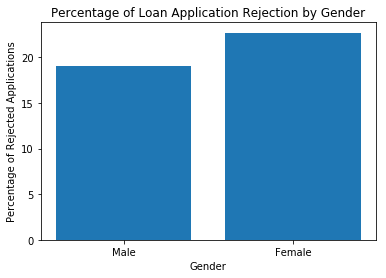

In [34]:
race = ['Male','Female']
reject = [19.005611, 22.710742]

plt.bar(race, reject)
plt.title('Percentage of Loan Application Rejection by Gender')
plt.xlabel('Gender')
plt.ylabel('Percentage of Rejected Applications')
plt.show()

Through the above graph, we can see that males face lower rates of loan rejection and higher rates of loan acceptance than females do. To further analyze, we will look into the intersection of race and gender to see which group has the lowest rejection rate.

In [36]:
white_male_action = df_race_action[(df_race_action['applicant_sex'] == 1) & (df_race_action['applicant_race_1'] == 5)]
white_male_demo = white_male_action['action_taken'].value_counts(normalize=True) * 100
white_male_demo

1    82.546645
3    17.453355
Name: action_taken, dtype: float64

In [37]:
black_male_action = df_race_action[(df_race_action['applicant_sex'] == 1) & (df_race_action['applicant_race_1'] == 3)]
black_male_demo = black_male_action['action_taken'].value_counts(normalize=True) * 100
black_male_demo

1    67.767625
3    32.232375
Name: action_taken, dtype: float64

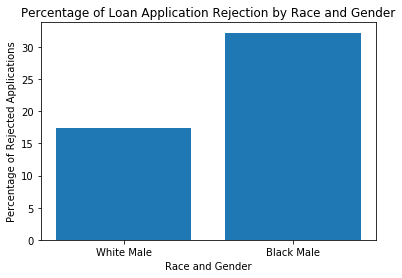

In [38]:
race = ['White Male','Black Male']
reject = [17.453355, 32.232375]

plt.bar(race, reject)
plt.title('Percentage of Loan Application Rejection by Race and Gender')
plt.xlabel('Race and Gender')
plt.ylabel('Percentage of Rejected Applications')
plt.show()

Based on the above graph, we can see that White males have a lower rate of rejection than Black males. From this analysis, we will develop our training set off of this demographic. 

## Building the Model 

Now, we will build our model that takes fairness into account. First, we will build the model using training data derived from White males. We believe that due to this intersectional group holding the lowest rejection rate in the dataset in the scope of our research, this will present the most fair subset of the data to pull from as we do not have training data that we can call inherently fair to build the model upon. In terms of the variables used, we will remove sensitive variables including race, ethnicity, sex, minority population percentage in an area, and geographic location to eliminate any biases. We will train the model using the variables of property type, loan type, loan purpose, owner occupancy, our engineered feature for loan to income ratio, and number of owner occupied units. We will develop this model using a Random Forest Classifier.

The reason why we picked these traits is based on correlation as well as the nature of the problem at hand. We created a correlation matrix for all the variables in this dataset and found significant correlations between property type, loan purposes, and purcharser type in relation to action taken with coefficients of 0.1322, 0.1544, and 0.3888 respectively. In addition, we trained on applicant income, loan amount, and loan to income ratio as well due to the financial nature of this situation as such factors would naturally be taken into consideration in any loan-based situation.

In [95]:
w_m_df =  df[(df['applicant_sex'] == 1) & (df['applicant_race_1'] == 5)]
w_m_df = w_m_df[['property_type', 'loan_type', 'loan_purpose', 'owner_occupancy', 'loan_amount_000s','applicant_income_000s',
                 'loan_to_income', 
                 'number_of_owner_occupied_units', 'action_taken','purchaser_type']]
w_m_df = w_m_df.astype({'action_taken': 'str', 'property_type':'str','loan_type':'str', 'loan_purpose':'str', 
                        'owner_occupancy':'str','purchaser_type':'str'})
w_m_df = w_m_df.dropna()


In [96]:
w_m_df.dtypes

property_type                      object
loan_type                          object
loan_purpose                       object
owner_occupancy                    object
loan_amount_000s                  float64
applicant_income_000s             float64
loan_to_income                    float64
number_of_owner_occupied_units    float64
action_taken                       object
purchaser_type                     object
dtype: object

In [98]:
clf = RandomForestClassifier(max_depth=10)
X = w_m_df[['loan_type', 'loan_purpose', 'loan_to_income', 'loan_amount_000s','applicant_income_000s','purchaser_type']]
y = w_m_df['action_taken']
clf.fit(X,y)



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [99]:
df_no_na = df.copy()
df_no_na = df_no_na[(df_no_na['applicant_race_1'] == 3) | (df_no_na['applicant_race_1'] == 5)]
df_no_na = df_no_na[['applicant_race_1','applicant_sex','applicant_income_000s','loan_amount_000s','property_type', 'loan_type', 'loan_purpose', 'owner_occupancy', 'loan_to_income', 
                 'number_of_owner_occupied_units', 'action_taken', 'purchaser_type']]
df_no_na = df_no_na.astype({'action_taken': 'str', 'property_type':'str','loan_type':'str', 'loan_purpose':'str', 
                        'owner_occupancy':'str','purchaser_type':'str'})
df_no_na = df_no_na.dropna()

# print(clf.predict(df_no_na[['property_type', 'loan_type', 'loan_purpose', 'owner_occupancy', 
#                             'loan_to_income', 'number_of_owner_occupied_units']]))
# df_no_na.head()

,applicant_race_1,applicant_sex,applicant_income_000s,loan_amount_000s,property_type,loan_type,loan_purpose,owner_occupancy,loan_to_income,number_of_owner_occupied_units,action_taken,purchaser_type
1,5,1,60.0,168.0,1,1,3,1,2.800000,861.0,3,0
3,5,2,53.0,88.0,1,1,3,2,1.660377,573.0,1,3
9,5,2,31.0,94.0,1,1,3,2,3.032258,1019.0,1,0
10,3,2,26.0,95.0,1,2,3,1,3.653846,2517.0,3,0
11,5,1,36.0,38.0,1,1,1,2,1.055556,2450.0,3,0


In [101]:
a = clf.predict(df_no_na[['loan_type', 'loan_purpose', 'loan_to_income', 'loan_amount_000s',
                          'applicant_income_000s','purchaser_type']])

# print(a)

['3' '1' '3' ... '3' '1' '1']


In [102]:
# from collections import Counter

# d = Counter(a)
# d

Counter({'3': 942001, '1': 6466359})

In [90]:
# df_no_na.action_taken.value_counts()

1    5979301
3    1429059
Name: action_taken, dtype: int64

In [91]:
# 5979301 /(5979301 + 1429059)

0.807101841703157

In [103]:
# 6466359 / (7369719 + 38641)

0.8728462169764968

In [104]:
df.corr()

,as_of_year,agency_code,loan_type,property_type,loan_purpose,owner_occupancy,loan_amount_000s,preapproval,action_taken,applicant_ethnicity,...,edit_status,sequence_number,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,application_date_indicator,loan_to_income
as_of_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agency_code,NaN,1.000000,0.036319,-0.041578,0.084329,-0.068010,0.015522,0.004056,0.098279,-0.068370,...,NaN,NaN,0.028828,0.121705,0.062484,0.047174,-0.003060,-0.015068,NaN,0.000783
loan_type,NaN,0.036319,1.000000,-0.065528,-0.065511,-0.169073,-0.010770,-0.102986,-0.009801,-0.059329,...,NaN,NaN,0.042257,0.013418,-0.094489,-0.090389,0.036677,0.060239,NaN,0.001627
property_type,NaN,-0.041578,-0.065528,1.000000,-0.082090,0.166910,0.080551,0.047942,0.132283,0.126012,...,NaN,NaN,-0.030728,-0.010669,-0.090146,-0.084726,-0.032735,-0.003871,NaN,-0.000979
loan_purpose,NaN,0.084329,-0.065511,-0.082090,1.000000,-0.012291,-0.004703,0.427368,0.154475,0.042079,...,NaN,NaN,-0.024404,0.043269,0.040944,-0.003248,-0.031418,-0.035869,NaN,-0.000547
owner_occupancy,NaN,-0.068010,-0.169073,0.166910,-0.012291,1.000000,0.064720,0.040720,-0.023138,0.205924,...,NaN,NaN,-0.056932,0.043603,-0.027892,-0.067713,-0.088858,-0.020751,NaN,-0.001745
loan_amount_000s,NaN,0.015522,-0.010770,0.080551,-0.004703,0.064720,1.000000,0.000026,-0.017124,0.052129,...,NaN,NaN,0.000240,0.010084,0.046151,0.049876,-0.006819,-0.014856,NaN,0.527540
preapproval,NaN,0.004056,-0.102986,0.047942,0.427368,0.040720,0.000026,1.000000,0.114047,0.041647,...,NaN,NaN,-0.023161,0.018730,0.008913,-0.003443,-0.026191,-0.022391,NaN,-0.000062
action_taken,NaN,0.098279,-0.009801,0.132283,0.154475,-0.023138,-0.017124,0.114047,1.000000,-0.002397,...,NaN,NaN,-0.021527,0.078611,-0.058063,-0.077220,-0.036930,-0.014781,NaN,0.002781
applicant_ethnicity,NaN,-0.068370,-0.059329,0.126012,0.042079,0.205924,0.052129,0.041647,-0.002397,1.000000,...,NaN,NaN,-0.045061,-0.157640,0.063695,0.040091,-0.001976,-0.007374,NaN,0.001184


Our model, using Random Forest Classifier and the selected variables, approved 87.28% of the applicants compared to the 80.71% that were approved in our original sample. We believe that developing this training model using the fairness metrics brought up earlier were beneficial in creating a more equal lending system. Now, we will look into the fairness of this algorithm through the lenses of Individual Fairness and Intersectionality. 